In [9]:
import sys
sys.path.append('./')

In [10]:
import time
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from ltp import get_pixel, ltp_calculated_pixel, show_output
from sklearn.svm import SVC, LinearSVC
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [11]:
def get_img(path):
  data = []
  for img in tqdm(os.listdir(path)):
    try:
        img = cv2.imread(os.path.join(path,img))  # read image into a list
        data.append(img)
    except Exception as ex:
      print(ex)
  return data

smiling_path = './data/smiling'
not_smiling_path = './data/not_smiling'

smiling_arr = get_img(smiling_path)
not_smiling_arr = get_img(not_smiling_path)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [12]:
len(not_smiling_arr)

4000

In [13]:
def extract_features(lst):
  height, width, channel = 64, 64, 3

  # Extract all features from the whole dataset (original + augmented)
  gray_imgs = []
  lbp_all = []
  hist_lbp_all = []

  for img in tqdm(lst):

      img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      img_gray = cv2.resize(img_gray, (64, 64))
      gray_imgs.append(img_gray)

      img_lpt_upper = np.zeros((height, width, 3), np.uint8)
      img_lpt_lower = np.zeros((height, width, 3), np.uint8)

      for i in range(0, height):
          for j in range(0, width):
              img_lpt_upper[i, j], img_lpt_lower[i,j] = ltp_calculated_pixel(img_gray, i, j)
      lbp_all.append(img_lpt_upper)
      hist_lbp = np.concatenate((cv2.calcHist([img_lpt_upper], [0], None, [256], [0, 256]), cv2.calcHist([img_lpt_lower], [0], None, [256], [0, 256])))
      hist_lbp_all.append(hist_lbp)

  lbp_all = np.array(lbp_all)
  hist_lbp_all = np.array(hist_lbp_all)
  return gray_imgs, lbp_all, hist_lbp_all

smiling_gray_imgs, smiling_lbp, smiling_hist_lbp = extract_features(smiling_arr)
not_smiling_gray_imgs, not_smiling_lbp, not_smiling_hist_lbp = extract_features(not_smiling_arr)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

c:\Users\ngocd\Desktop\smile\ltp.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  current_plot.set_yticklabels(ytick_list,rotation = 90)


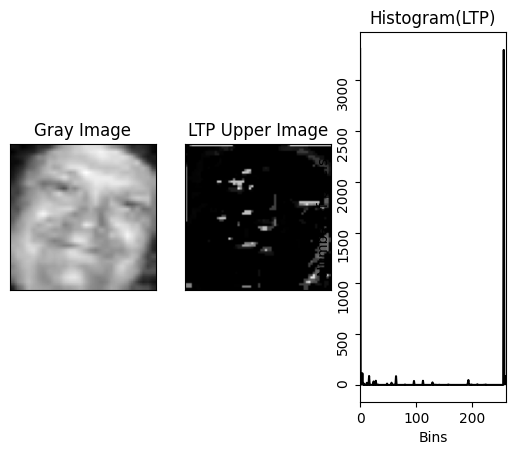

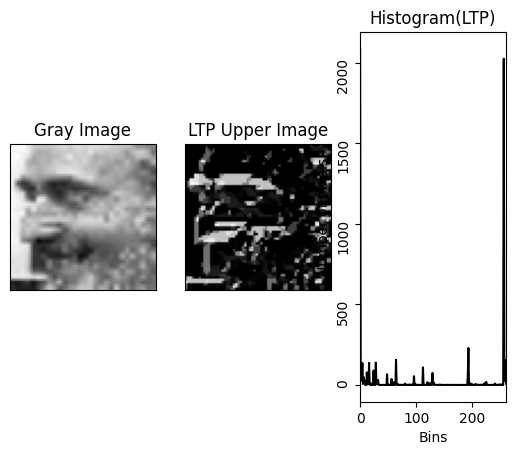

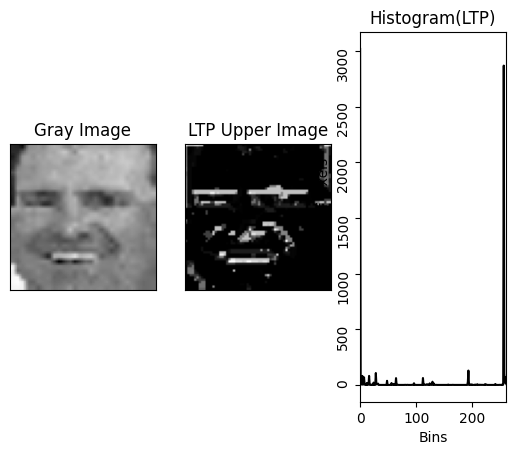

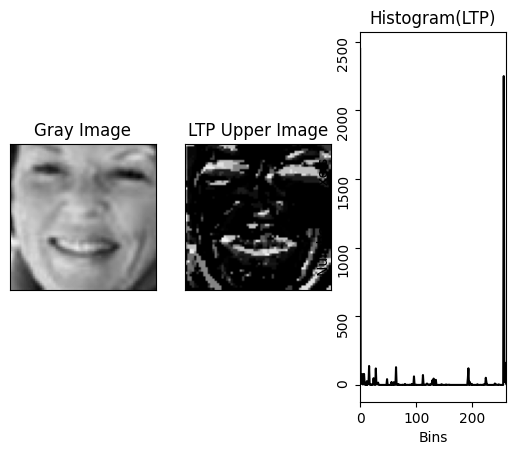

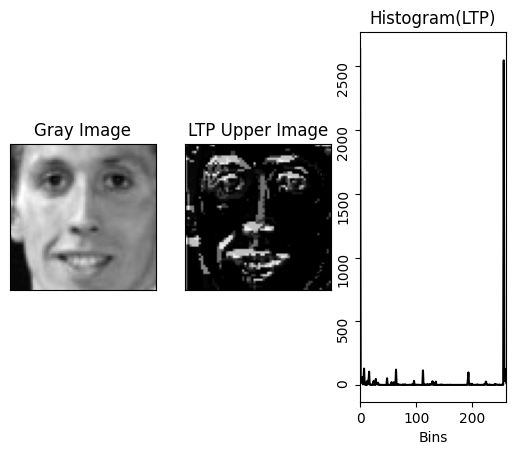

In [14]:
# To visualise the 5 extracted features
for i in range(5500, 5505):

        output_list = []
        output_list.append({
            "img": smiling_gray_imgs[i],
            "xlabel":"",
            "ylabel":"",
            "xtick": [],
            "ytick": [],
            "title":"Gray Image",
            "type":"gray"
         })

        output_list.append({
            "img": smiling_lbp[i],
            "xlabel":"",
            "ylabel":"",
            "xtick": [],
            "ytick": [],
            "title":"LTP Upper Image",
            "type":"gray"
         })

        output_list.append({
            "img": smiling_hist_lbp[i],
            "xlabel":"Bins",
            "ylabel":"Number of pixels",
            "xtick": None,
            "ytick": None,
            "title":"Histogram(LTP)",
            "type":"histogram"
         })

        show_output(output_list)

In [15]:
smiling_data = []

for i, features in enumerate(smiling_hist_lbp):
    try:
        img_gray = cv2.cvtColor(smiling_gray_imgs[i], cv2.IMREAD_GRAYSCALE)
        smiling_data.append([features, 1, img_gray])
    except Exception as ex:
        print(ex)

not_smiling_data = []

for i, features in enumerate(not_smiling_hist_lbp):
    try:
        img_gray = cv2.cvtColor(not_smiling_gray_imgs[i], cv2.IMREAD_GRAYSCALE)
        not_smiling_data.append([features, 0, img_gray])
    except Exception as ex:
        print(ex)

In [16]:
smiling_train, smiling_test = train_test_split(smiling_data, train_size=0.8)
not_smiling_train, not_smiling_test = train_test_split(not_smiling_data, train_size=0.8)

train_data = []
train_data.extend(smiling_train)
train_data.extend(not_smiling_train)
random.shuffle(train_data)

test_data = []
test_data.extend(smiling_test)
test_data.extend(not_smiling_test)
random.shuffle(test_data)

len(train_data)

8000

In [17]:
X_train = []
y_train = []
gray_img_train = []
subcls_num = []

for features, label, gray in train_data:
    X_train.append(features)
    y_train.append(label)
    gray_img_train.append(gray)

X_train = np.array(X_train).reshape(len(y_train), -1)
y_train = np.array(y_train)

print(X_train.shape)

(8000, 512)


In [18]:
# Create testing set

X_test = []
y_test = []
gray_img_test = []

for features, label, gray in test_data:
    X_test.append(features)
    y_test.append(label)
    gray_img_test.append(gray)

X_test = np.array(X_test).reshape(len(y_test), -1)
y_test = np.array(y_test)

print(X_test.shape)

(2000, 512)


In [19]:
# Normalize the data

scaling = StandardScaler()
scaling.fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [20]:
# Train the classifier

svm = LinearSVC(C=1, max_iter=500000, verbose=2)   # LinearSVC is faster than SVC

start_train = time.time() # to record the training time
svm.fit(X_train, y_train)
end_train = time.time()
print(end_train - start_train, "seconds")

[LibLinear]

c:\Users\ngocd\Desktop\smile\env\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


927.2982378005981 seconds


In [21]:
y_pred = svm.predict(X_train)

ill_pred = y_pred

print("Classification report for - \n{}:\n{}\n".format(
    svm, metrics.classification_report(y_train, y_pred)))

train_acc = metrics.accuracy_score(y_train, y_pred)*100
print("Training accuracy: " + str(train_acc))

Classification report for - 
LinearSVC(C=1, max_iter=500000, verbose=2):
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      3200
           1       0.85      0.88      0.87      4800

    accuracy                           0.84      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.84      0.84      0.84      8000


Training accuracy: 83.7


In [22]:
y_pred = svm.predict(X_test)

print("Classification report for - \n{}:\n{}\n".format(
    svm, metrics.classification_report(y_test, y_pred)))

test_acc = metrics.accuracy_score(y_test, y_pred)*100
print("Testing accuracy: " + str(test_acc))

Classification report for - 
LinearSVC(C=1, max_iter=500000, verbose=2):
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       800
           1       0.83      0.84      0.84      1200

    accuracy                           0.80      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.80      0.80      0.80      2000


Testing accuracy: 80.10000000000001


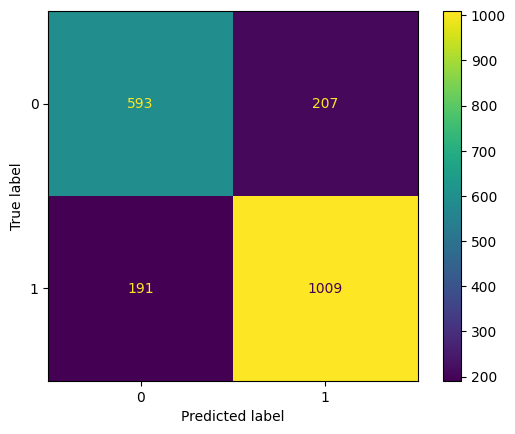

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svm.classes_)
disp.plot()
plt.show()

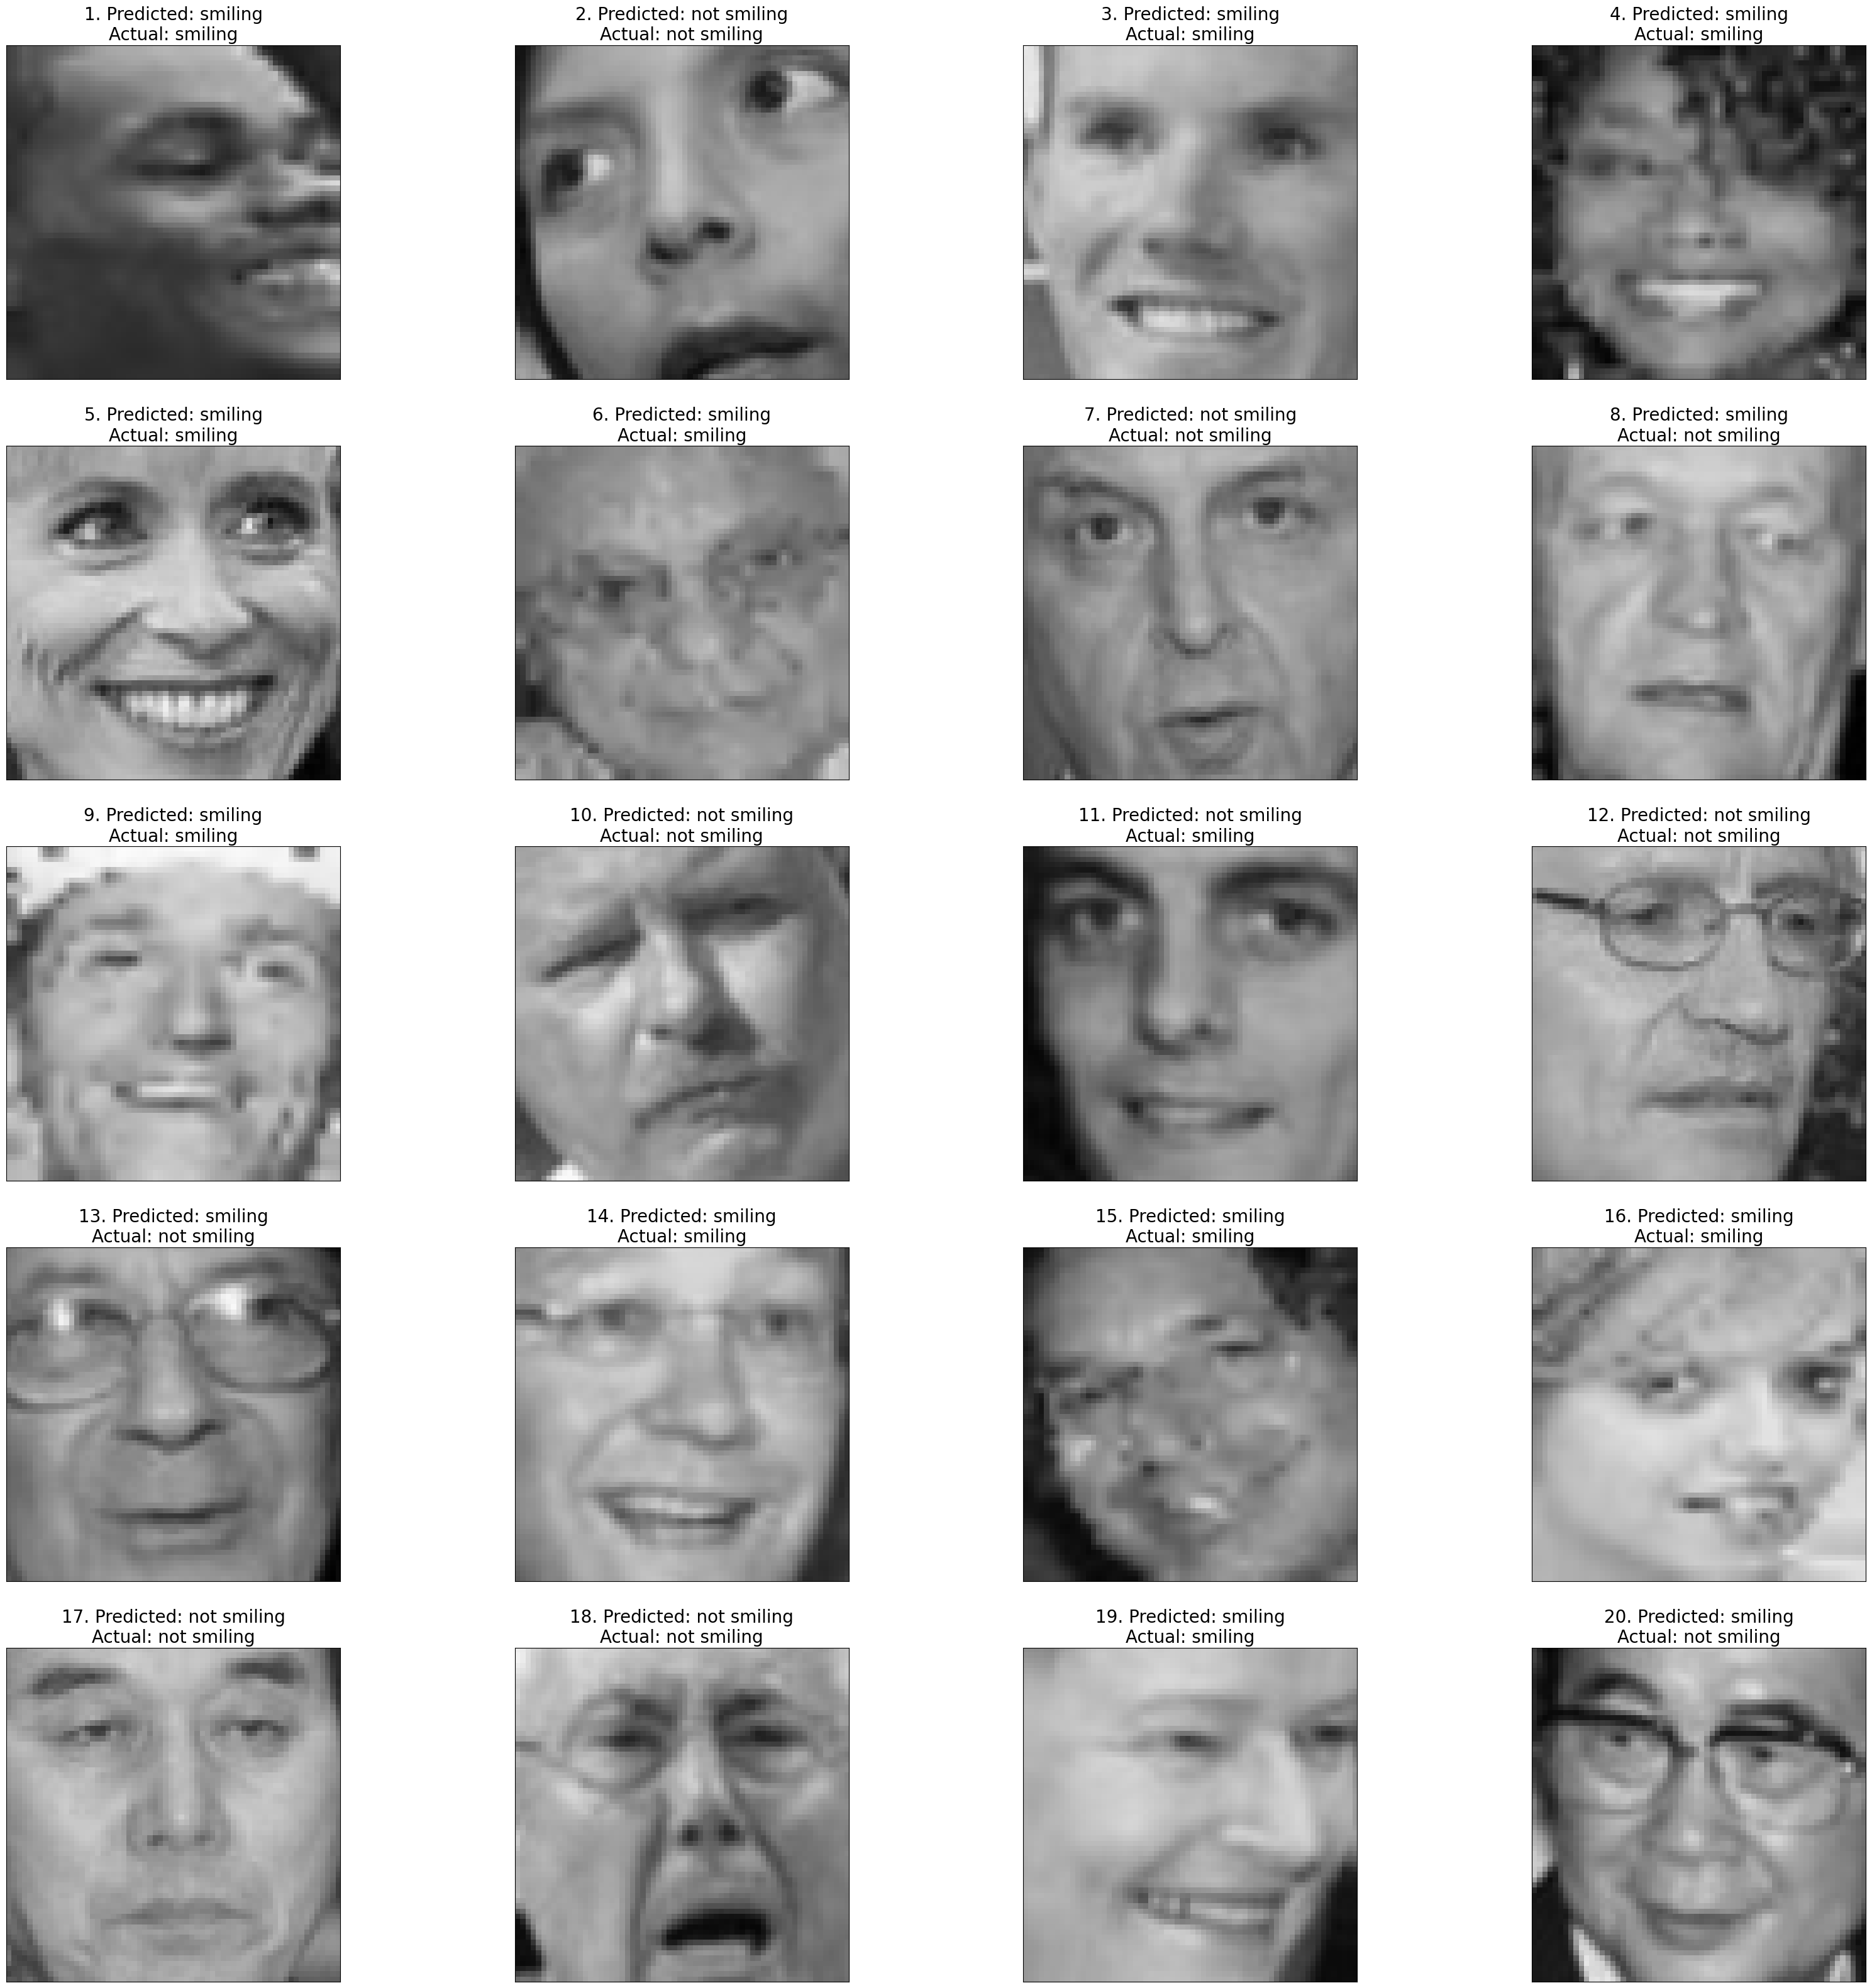

In [24]:
def plot(test_data, row, col, gray, labels):
    plt.figure(figsize=(40, 40))
    plt.tight_layout()
    for i in range(0,row*col):
        plt.subplot(row, col, i+1)
        predicted = y_pred[i]
        actual = y_test[i]
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        title = str(i+1) + '. Predicted: ' + labels[predicted] + '\nActual: ' + labels[actual]
        plt.title(title, fontdict = {'fontsize' : "20"})
        plt.imshow(gray_img_test[i], cmap='gray')

    plt.show()


# To visualise misclassified samples
col = 4
row = 5
plot(test_data, row, col, gray_img_test, ["not smiling", "smiling"])

In [27]:
import pickle

pickle.dump(svm, open('./model/ltp_model.sav', 'wb'))